In [4]:
df_tcell = pd.read_csv("tcell_virus_tetramer.csv");
df_tcell

,allele,peptide,fraction_entries_positive,num_entries,num_entries_with_subjects,num_subjects,num_subjects_positive,fraction_subjects_positive,in_sars2,species_prefix,species,mhc_gene_name,mhc_class
0,H2-Db,AAIENYVRF,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I
1,H2-Db,AAVKNWMTQTL,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I
2,H2-Db,AGPHNDMEI,0.863636,22,2,18.0,16.0,0.888889,False,H2,mouse,D,I
3,H2-Db,ASNENMDAM,0.578947,19,0,0.0,0.0,0.000000,False,H2,mouse,D,I
4,H2-Db,ASNENMDTM,1.000000,3,0,0.0,0.0,0.000000,False,H2,mouse,D,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,SLA-2*0401,MTAHITVPY,1.000000,1,1,4.0,4.0,1.000000,False,SLA,pig,2,?
2621,SLA-2*0401,SKFTFSIPY,0.000000,1,1,5.0,0.0,0.000000,False,SLA,pig,2,?
2622,SLA-2*0401,SSVGVTHGY,1.000000,1,1,4.0,4.0,1.000000,False,SLA,pig,2,?
2623,SLA-2*0401,TNTQNNDWF,1.000000,1,1,5.0,5.0,1.000000,False,SLA,pig,2,?


In [5]:
df_tcell.fraction_entries_positive.isnull().mean()

0.0

In [6]:
import mhcflurry
from mhctools import MHCflurry
pred = mhcflurry.Class1PresentationPredictor.load()
supported_alleles = set(pred.supported_alleles)

df_tcell["mhcflurry_allele_name"] = df_tcell.allele.str.replace("H2", "H-2")

df_tcell_mouse_and_human = df_tcell[df_tcell.species.isin({"human", "mouse"})]

df_tcell_mouse_and_human_class1 = df_tcell_mouse_and_human[
    df_tcell_mouse_and_human.mhc_class == "I"]

df_tcell_mhcflurry = df_tcell_mouse_and_human_class1[
    (df_tcell_mouse_and_human_class1.mhcflurry_allele_name.isin(supported_alleles)) &
    (df_tcell_mouse_and_human_class1.peptide.str.len() < 16)]

print("Selected %d/%d pMHCs for prediction with MHCflurry" % (
    len(df_tcell_mhcflurry),
    len(df_tcell)))
print("%0.2f%% of label values null" % (
    df_tcell_mhcflurry.fraction_entries_positive.isnull().mean() * 100))


Selected 1214/2625 pMHCs for prediction with MHCflurry
0.00% of label values null


In [7]:
df_pred = pred.predict(
    peptides=df_tcell_mhcflurry.peptide.values,
    alleles={allele:[allele] for allele in df_tcell_mhcflurry.mhcflurry_allele_name.unique()},
    sample_names=df_tcell_mhcflurry.mhcflurry_allele_name.values)

  0%|          | 0/1 [00:00<?, ?it/s]

Predicting processing.


  0%|          | 0/68 [00:00<?, ?it/s]

Predicting affinities.


100%|██████████| 68/68 [00:07<00:00,  9.05it/s]


In [8]:
df_pred.index

RangeIndex(start=0, stop=1214, step=1)

In [9]:
df_pred.to_csv("tcell_virus_tetramer_class1_mhcflurry_predictions.csv", index=False)

In [189]:
len(df_pred), len(df_tcell_mhcflurry)

(1214, 1214)

In [225]:
mask = (
    (df_tcell_mhcflurry.fraction_entries_positive < 0.3) | 
    (df_tcell_mhcflurry.fraction_entries_positive > 0.7))
print(mask.isnull().mean())
mask = mask.values
label = (df_tcell_mhcflurry.fraction_entries_positive > 0.5)
print(label.isnull().mean())
label = label.values
label_subset = label[mask].copy()
df_pred_subset = df_pred[mask].copy()
df_pred_subset["label"] = label_subset
df_pred_subset["score"] = np.maximum(
    1.0 - np.log10(df_pred_subset.affinity)/np.log10(50*10**3), df_pred_subset.processing_score)
print(len(label_subset), label_subset.sum(), df_pred_subset.label.isnull().mean())

0.0
0.0
1128 679 0.0


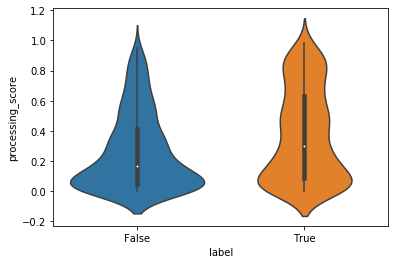

In [226]:
import seaborn
seaborn.violinplot(
    data=df_pred_subset, 
    y="processing_score",
    x="label")

In [227]:
from sklearn.metrics import roc_auc_score, f1_score

In [228]:
roc_auc_score(y_true=label_subset, y_score=df_pred_subset.processing_score.values)

0.6012050998619087

In [229]:
roc_auc_score(y_true=label_subset, y_score=df_pred_subset.presentation_score.values)

0.6124229592188172

In [230]:
roc_auc_score(y_true=label_subset, y_score=-df_pred_subset.affinity.values)

0.5990336896589049

In [231]:
roc_auc_score(y_true=label_subset, y_score=df_pred_subset.score.values)

0.6187846663014849

In [148]:
df_tcell_mouse_and_human_class1

,allele,peptide,fraction_entries_positive,num_entries,num_entries_with_subjects,num_subjects,num_subjects_positive,fraction_subjects_positive,in_sars2,species_prefix,species,mhc_gene_name,mhc_class,mhcflurry_allele_name
0,H2-Db,AAIENYVRF,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
1,H2-Db,AAVKNWMTQTL,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
2,H2-Db,AGPHNDMEI,0.863636,22,2,18.0,16.0,0.888889,False,H2,mouse,D,I,H-2-Db
3,H2-Db,ASNENMDAM,0.578947,19,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
4,H2-Db,ASNENMDTM,1.000000,3,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,HLA-C*07:02,CRVLCCYVL,1.000000,1,0,0.0,0.0,0.000000,False,HLA,human,C,I,HLA-C*07:02
1253,HLA-C*07:02,FRKDVNMVL,1.000000,1,1,10.0,8.0,0.800000,False,HLA,human,C,I,HLA-C*07:02
1254,HLA-C*07:02,TPRVTGGGAM,1.000000,1,0,0.0,0.0,0.000000,False,HLA,human,C,I,HLA-C*07:02
1255,HLA-C*08:01,FLGPLLVLQA,1.000000,1,0,0.0,0.0,0.000000,False,HLA,human,C,I,HLA-C*08:01


In [109]:
df_pred

,peptide,peptide_num,sample_name,affinity,best_allele,processing_score,presentation_score
0,AAIENYVRF,0,H-2-Db,35.939434,H-2-Db,0.535547,0.915806
1,AAVKNWMTQTL,1,H-2-Db,54.257879,H-2-Db,0.146693,0.654062
2,AGPHNDMEI,2,H-2-Db,39.029623,H-2-Db,0.055071,0.646046
3,ASNENMDAM,3,H-2-Db,28.360595,H-2-Db,0.005191,0.669574
4,ASNENMDTM,4,H-2-Db,26.689156,H-2-Db,0.005358,0.681474
...,...,...,...,...,...,...,...
1209,CRVLCCYVL,1209,HLA-C*07:02,123.605679,HLA-C*07:02,0.001070,0.352100
1210,FRKDVNMVL,1210,HLA-C*07:02,34.151154,HLA-C*07:02,0.356372,0.857338
1211,TPRVTGGGAM,1211,HLA-C*07:02,4672.527432,HLA-C*07:02,0.390996,0.080797
1212,FLGPLLVLQA,1212,HLA-C*08:01,5290.585710,HLA-C*08:01,0.217904,0.040771
